### Generate a signal

We use some functions from the ``data`` module to generate data. FIrst generate a signal:

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
I0000 00:00:1725621478.607026  125413 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0.5, 1.0, 'Signal')

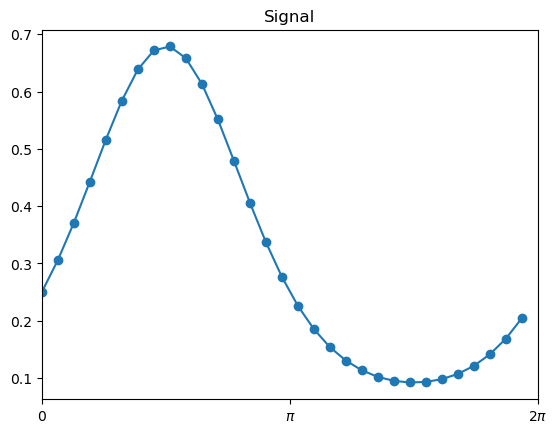

In [1]:
import matplotlib.pyplot as plt
from data import get_signal, get_samples
from plot import signal_plot_setup
import jax.numpy as jnp


L = 31
x, t = get_signal(L)

plt.plot(t, x, 'o-')
signal_plot_setup(plt.gca())
plt.title('Signal')

### Generate samples
Generate samples for an existing signal using ``get_samples`` function.

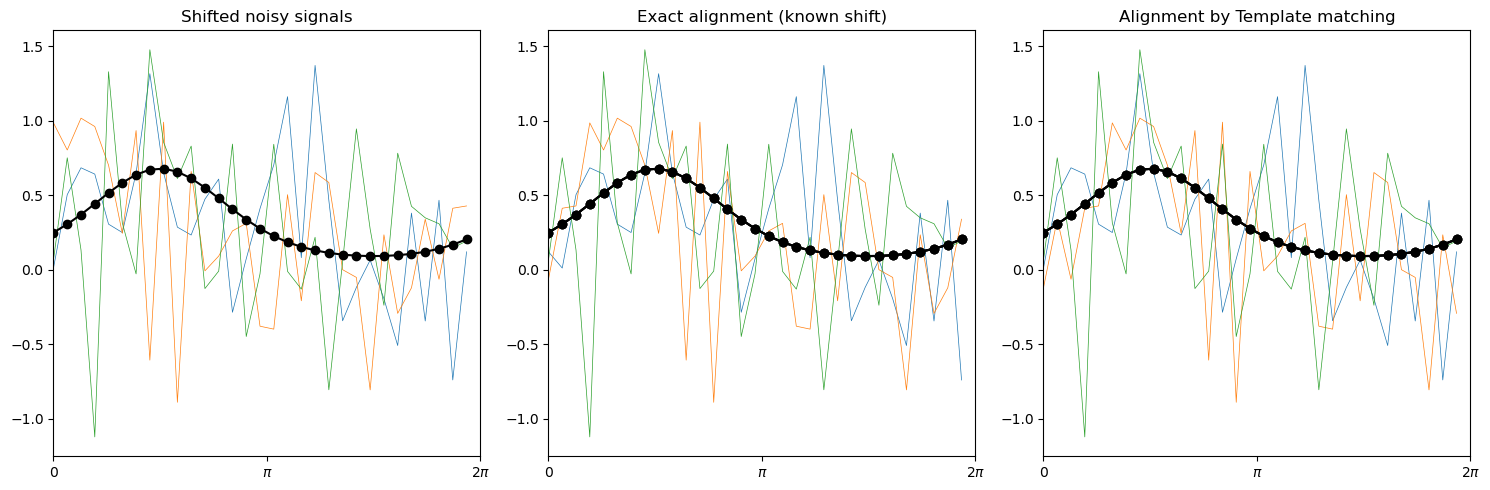

In [2]:
from jax.random import PRNGKey
from utils import align_to_signal

std = 0.5
N = 5000
y, noise, shift = get_samples(PRNGKey(0), x, std, N)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
for i in range(min(3, N)):
    plt.plot(t, y[i], '-', linewidth=0.5)
plt.plot(t, x, 'ko-')
signal_plot_setup(plt.gca())
plt.title('Shifted noisy signals')

plt.subplot(1, 3, 2)
for i in range(min(3, N)):
    plt.plot(t, jnp.roll(y[i], -shift[i]), '-', linewidth=0.5)
    plt.plot(t, x, 'ko-')
signal_plot_setup(plt.gca())
plt.title('Exact alignment (known shift)')

plt.subplot(1, 3, 3)
for i in range(min(3, N)):
    plt.plot(t, align_to_signal(y[i], x), '-', linewidth=0.5)
    plt.plot(t, x, 'ko-')
signal_plot_setup(plt.gca())
plt.title('Alignment by Template matching')

plt.tight_layout()

## Reconstruction
We will generate reconstructions using phase synchronization, Expectation-maximization and moment constrained alignment. We create a wrapper to time the reconstructions.

In [3]:
from bsi import bsi
from em import em
from mca import mca
from utils import align_to_signal, relative_error
import time

def timefunc(func, N):
    def wrapped(*args, **kwargs):
        start = time.time()
        for n in range(N):
            res = func(*args, **kwargs)
        return res, (time.time() - start)/N
    return wrapped

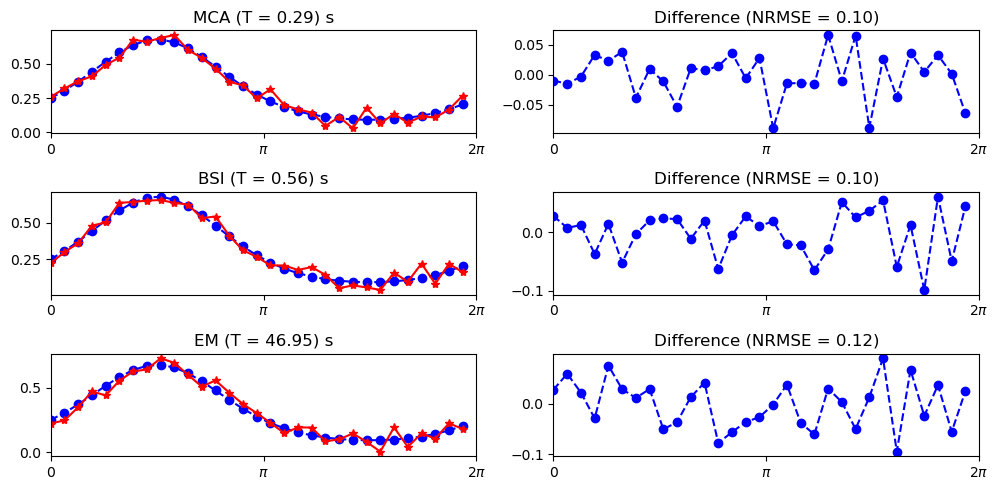

In [4]:
Nrep = 3
x0 = jnp.sin(t)
x_bsi, T_bsi = timefunc(bsi, Nrep)(y, std)
x_em, T_em = timefunc(em, Nrep)(y, std, x0)
x_mca, T_mca = timefunc(mca, Nrep)(y, std, x0)

x_recs = [x_mca, x_bsi, x_em]
T_recs = [T_mca, T_bsi, T_em]
titles = ['MCA', 'BSI', 'EM']

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(3, 2, 2*i + 1)
    x_aligned = align_to_signal(x_recs[i], x)
    delta = x - x_aligned
    
    plt.plot(t, x, 'bo--')
    plt.plot(t, x_aligned, 'r*-')
    signal_plot_setup(plt.gca())
    plt.title(titles[i] + f" (T = {T_recs[i]:.2f}) s")
    
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(t, x-x_aligned, 'bo--')
    signal_plot_setup(plt.gca())
    plt.title("Difference (NRMSE = %.2f)" % relative_error(x, x_aligned))

plt.tight_layout()  